In [1]:
import mikeio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pynori.plotter import scatter

# Load model results

In [2]:
def depth_corrector(coordinates, correction_value, change_sign=False):
    coordinates[:, 2] = coordinates[:, 2] + correction_value
    if change_sign:
        coordinates[:, 2] = -coordinates[:, 2]
    return coordinates

In [3]:
def get_layers(coordinates):
    layers = np.unique(coordinates[:, 2])
    return layers

In [4]:
def find_layer_coordinates(coordinates, layers, layer_no):
    layer = layers[layer_no]
    layer_coordinates = coordinates[coordinates[:, 2] == layer]
    layer_indices = np.where(coordinates[:, 2] == layer)[0]
    return layer_indices, layer_coordinates

In [21]:
def find_closest_layer_index(layers, observation_depth):
    if observation_depth < layers[0]:
        return np.nan
    if observation_depth > layers[-1]:
        return np.nan
    return np.argmin(np.abs(layers - observation_depth))

In [24]:
def find_values_within_radius(layer_values, layer_coordinates, observation_coordinates, radius):
    distances = np.sqrt((layer_coordinates[:, 0] - observation_coordinates[0]) ** 2 + (layer_coordinates[:, 1] - observation_coordinates[1]) ** 2)
    return layer_values[distances < radius]

In [5]:
model_pr1 = r"\\USDEN1-STOR.DHI.DK\Projects\41806287\Models\Midwater\05_runs\rev3\midwater_plume_pr1test.m3fm - Result Files\Separate files\Total SSC.dfsu"
dfsu = mikeio.read(model_pr1)[0]

100%|██████████| 1891/1891 [00:27<00:00, 68.17it/s]


In [12]:
element_coordinates = dfsu.geometry.element_coordinates.copy()
depth_correction = -1200
change_sign = True
element_coordinates = depth_corrector(element_coordinates, depth_correction, change_sign)
layers = get_layers(element_coordinates)
values = dfsu.values.copy()
times = dfsu.time.copy()

In [8]:
ROV = pd.read_csv(r"\\USDEN1-STOR.DHI.DK\Projects\41806287\41806287 NORI-D Data\Workflow Execution\ROV CTD Calibration\observations\ROV\near field\01_near_field_ROV_CTD.csv", index_col=0, parse_dates=True)
ROV_x = ROV["ROV Easting"].to_numpy().copy()
ROV_y = ROV["ROV Northing"].to_numpy().copy()
ROV_z = ROV["ROV Depth"].to_numpy().copy()
ROV_coordinates = np.vstack((ROV_x, ROV_y, ROV_z)).T
ROV_time = ROV.index.copy()
ROV_values = ROV["SSC (mg/L)"].to_numpy().copy()

In [26]:
outputs = {"Min": [], "P1": [], "P5": [], "P10": [], "Mean": [], "P90": [], "P95": [], "P99": [], "Max": []}
time_intersection = times.intersection(ROV_time)
for i, time in enumerate(time_intersection):
    time_index = np.where(times == time)[0][0]
    ROV_time_index = np.where(ROV_time == time)[0][0]
    ROV_depth = ROV_coordinates[ROV_time_index, 2]
    ROV_xy = ROV_coordinates[ROV_time_index, :2]
    layer_index = find_closest_layer_index(layers, ROV_depth)
    if np.isnan(layer_index):
        continue
    layer_indices, layer_coordinates = find_layer_coordinates(element_coordinates, layers, layer_index)
    layer_values = values[time_index, layer_indices]
    output_values = find_values_within_radius(layer_values, layer_coordinates, ROV_xy, 100)
    if len(output_values) == 0:
        continue
    outputs["Min"].append(np.min(output_values))
    outputs["P1"].append(np.percentile(output_values, 1))
    outputs["P5"].append(np.percentile(output_values, 5))
    outputs["P10"].append(np.percentile(output_values, 10))
    outputs["Mean"].append(np.mean(output_values))
    outputs["P90"].append(np.percentile(output_values, 90))
    outputs["P95"].append(np.percentile(output_values, 95))
    outputs["P99"].append(np.percentile(output_values, 99))
    outputs["Max"].append(np.max(output_values))
    print(len(output_values))


1
1
1
1
1
1
1
0
1
0
1
1
2
1
0
0
1
1
1
1
2
1
2
1
1
0
1
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
0
0
1
0
1
0
1
0
1
0
0
1
1
1
1
1
1
0
0
0
2
0
1
2
0
0
1
1
0
0
2
0
1
2
2
0
1
0
1
0
1
1
0
0
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
2
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
0
1
0
1
2
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
1
0
0
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
2
1
1
0
2
0
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
0
1
2
1
0
2
0
1
1
1
1
0
0
0
0
0
1
1
1
1
1
1
0
1
2
1
0
1
2
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
0
0
1
2
1
1
0
1
1
0
1
2
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
0
0
0
0
1
0
1
1
1
1
0
2
2
1
1
0
1
1
1
1
2
1
1
1
1
0
1
1
1
0
0
0
0
1
1
0
0
1
1
1
1
0
1
1
1
0
1
1
1


In [12]:
output_df[['Mean', 'Min', 'Max', 'P1', 'P5', 'P95', 'P99']] = output_df[['Mean', 'Min', 'Max', 'P1', 'P5', 'P95', 'P99']] * 1000

Text(0, 0.5, 'Depth (m)')

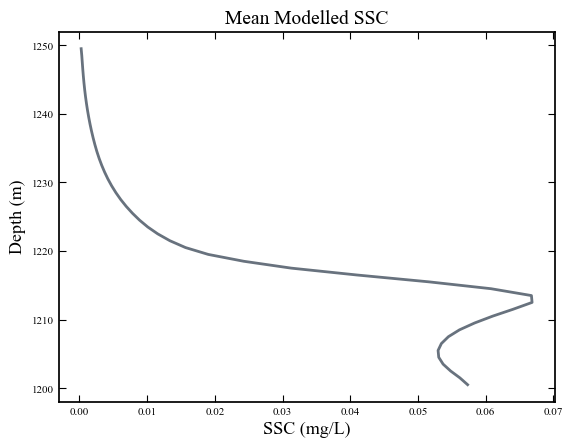

In [21]:
plt.plot(output_df['Mean'], output_df['Depth'], label='Mean')
plt.title('Mean Modelled SSC')
plt.xlabel('SSC (mg/L)')
plt.ylabel('Depth (m)')

In [17]:
ROV = pd.read_csv(r"\\USDEN1-STOR.DHI.DK\Projects\41806287\41806287 NORI-D Data\Workflow Execution\ROV CTD Calibration\observations\ROV\near field\01_near_field_ROV_CTD.csv", index_col=0)
mask = (ROV["ROV Depth"] > 1200) & (ROV["ROV Depth"] < 1300)
ROV = ROV[mask]
ROV = ROV[["ROV Depth", "SSC (mg/L)"]]
mask = ROV["SSC (mg/L)"] < 1e-5
ROV = ROV[~mask]
ROV = ROV.dropna()

#time_intersection = (model_times + pd.Timedelta(seconds=1)).intersection(ROV.index)
#ROV = ROV.loc[time_intersection]

ROV_depth = ROV["ROV Depth"].to_numpy()
ROV_SSC = ROV["SSC (mg/L)"].to_numpy()
ROV_depth_bins = np.arange(1200, 1300, 2)
ROV_SSC_bins = np.arange(0, 70, 5)

0.0


(0.0, 300.0)

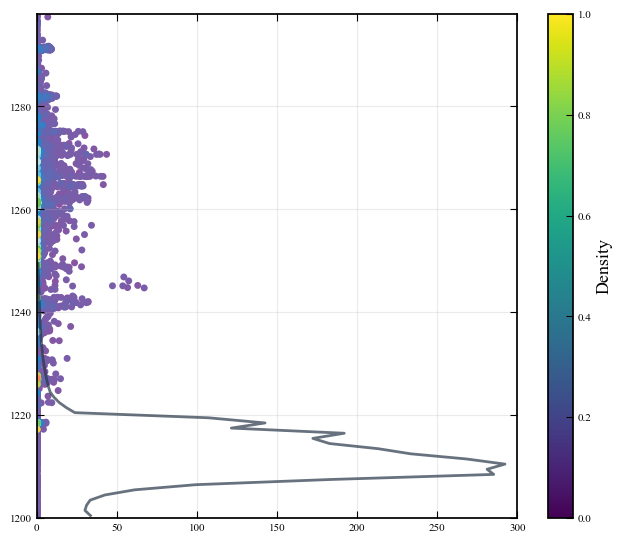

In [18]:
fig, ax = scatter(ROV_SSC, ROV_depth, ROV_SSC_bins, ROV_depth_bins)
ax.plot(output_df['Max'], output_df['Depth'], label='Mean')
ax.set_xlim([0, 300])

0.0


Text(0.5, 1.0, 'ROV SSC Calibration')

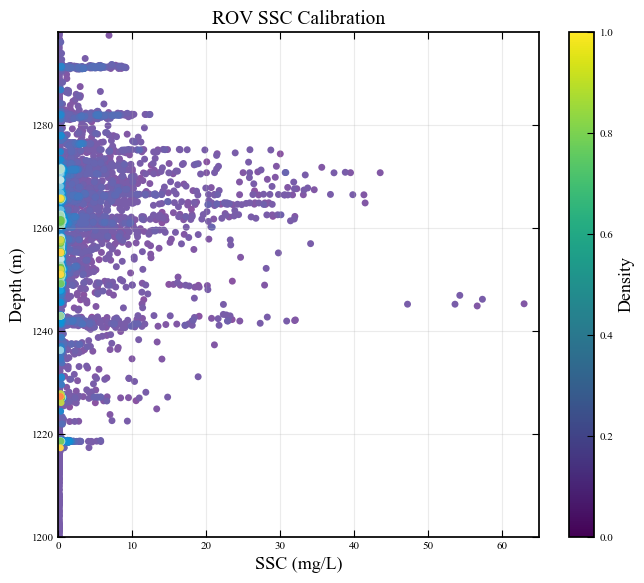

In [20]:
fig, ax = scatter(ROV_SSC, ROV_depth, ROV_SSC_bins, ROV_depth_bins)
ax.set_xlabel("SSC (mg/L)")
ax.set_ylabel("Depth (m)")
ax.set_title("ROV SSC Calibration")